# Image Classification Prediction

This tutorial introduces how to call the pretraining model in MindCV to make classification prediction on the test image.

## Model Loading

### View All Available Models

By calling the `registry.list_models` function in `mindcv.models`, the names of all network models can be printed. The models of a network in different parameter configurations will also be printed, such as resnet18 / resnet34 / resnet50 / resnet101 / resnet152.

In [1]:
import sys
sys.path.append("..")
from mindcv.models import registry
registry.list_models()

['BiTresnet50',
 'RepMLPNet_B224',
 'RepMLPNet_B256',
 'RepMLPNet_D256',
 'RepMLPNet_L256',
 'RepMLPNet_T224',
 'RepMLPNet_T256',
 'convit_base',
 'convit_base_plus',
 'convit_small',
 'convit_small_plus',
 'convit_tiny',
 'convit_tiny_plus',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'dpn107',
 'dpn131',
 'dpn92',
 'dpn98',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'efficientnet_v2_xl',
 'ghostnet_1x',
 'ghostnet_nose_1x',
 'googlenet',
 'inception_v3',
 'inception_v4',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mnasnet1_4',
 'mobilenet_v1_025_224',
 'mobilenet_v1_050_224',
 'mobilenet_v1_075_224',
 'mobilenet_v1_100_224',
 'mobilenet_v2_035_128',
 'mobilenet_v2_035_160

### Load Pretraining Model

Taking the resnet50 model as an example, we introduce two methods to load the model checkpoint using the `create_model` function in `mindcv.models`. 1). When the `pretrained` parameter in the interface is set to True, network weights can be automatically downloaded.

In [2]:
from mindcv.models import create_model
model = create_model(model_name='resnet50', num_classes=1000, pretrained=True)
# Switch the execution logic of the network to the inference scenario
model.set_train(False)

102453248B [00:16, 6092186.31B/s]                                                                                      


ResNet<
  (conv1): Conv2d<input_channels=3, output_channels=64, kernel_size=(7, 7), stride=(2, 2), pad_mode=pad, padding=3, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
  (bn1): BatchNorm2d<num_features=64, eps=1e-05, momentum=0.9, gamma=Parameter (name=bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), beta=Parameter (name=bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=bn1.moving_mean, shape=(64,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=bn1.moving_variance, shape=(64,), dtype=Float32, requires_grad=False)>
  (relu): ReLU<>
  (max_pool): MaxPool2d<kernel_size=3, stride=2, pad_mode=SAME>
  (layer1): SequentialCell<
    (0): Bottleneck<
      (conv1): Conv2d<input_channels=64, output_channels=64, kernel_size=(1, 1), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
      (bn1): Batc

2). When the `checkpoint_path` parameter in the interface is set to the file path, the model parameter file with the `.ckpt` can be loaded.

In [3]:
from mindcv.models import create_model
model = create_model(model_name='resnet50', num_classes=1000, checkpoint_path='./resnet50_224.ckpt')
# Switch the execution logic of the network to the inference scenario
model.set_train(False)

ResNet<
  (conv1): Conv2d<input_channels=3, output_channels=64, kernel_size=(7, 7), stride=(2, 2), pad_mode=pad, padding=3, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
  (bn1): BatchNorm2d<num_features=64, eps=1e-05, momentum=0.9, gamma=Parameter (name=bn1.gamma, shape=(64,), dtype=Float32, requires_grad=True), beta=Parameter (name=bn1.beta, shape=(64,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=bn1.moving_mean, shape=(64,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=bn1.moving_variance, shape=(64,), dtype=Float32, requires_grad=False)>
  (relu): ReLU<>
  (max_pool): MaxPool2d<kernel_size=3, stride=2, pad_mode=SAME>
  (layer1): SequentialCell<
    (0): Bottleneck<
      (conv1): Conv2d<input_channels=64, output_channels=64, kernel_size=(1, 1), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
      (bn1): Batc

## Data Preparation

### Create Dataset

Here, we download a Wikipedia image as a test image, and use the `create_dataset` function in `mindcv.data` to construct a custom dataset for a single image.

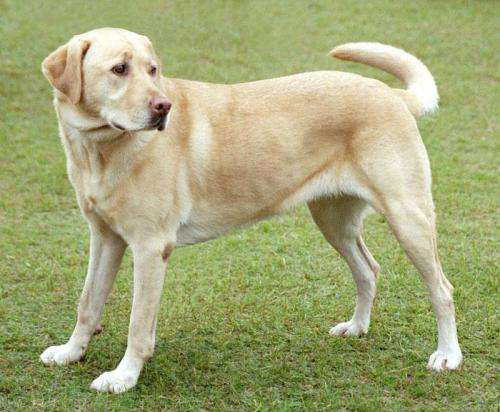

In [4]:
from mindcv.data import create_dataset
num_workers = 1
# path of dataset
data_dir = "./data/"
dataset = create_dataset(root=data_dir, split='test', num_parallel_workers=num_workers)
# Image visualization
from PIL import Image
Image.open("./data/test/dog/dog.jpg")

The directory structure of the dataset is as follows:

```Text
data/
└─ test
    ├─ dog
    │   ├─ dog.jpg
    │   └─ ……
    └─ ……
```

### Data Preprocessing

Call the `create_transforms` function to obtain the data processing strategy (transform list) of the ImageNet dataset used by the pre training model.

We pass the obtained transform list into the `create_loader` function, specify `batch_size=1` and other parameters, and then complete the preparation of test data. The `Dataset` object is returned as the input of the model.

In [5]:
from mindcv.data import create_transforms, create_loader
transforms_list = create_transforms(dataset_name='imagenet', is_training=False)
data_loader = create_loader(
        dataset=dataset,
        batch_size=1,
        is_training=False,
        num_classes=1000,
        transform=transforms_list,
        num_parallel_workers=num_workers
    )

## Model Inference
The picture of the user-defined dataset is transferred to the model to obtain the inference result. Here, use the `Squeeze` function of `mindspore.ops` to remove the batch dimension.


In [6]:
import mindspore.ops as P
import numpy as np
images, _ = next(data_loader.create_tuple_iterator())
output = P.Squeeze()(model(images))
pred = np.argmax(output.asnumpy())

In [7]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())
print('predict: {}'.format(idx2label[pred]))

predict: Labrador retriever
